# Сеть для классификации изображений

Датасет MNIST представляет из себя черно-белые изображения 28 на 28 пикселей

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense, Flatten

## Выгружаем данные

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

Отрисуем первые пять картинок:

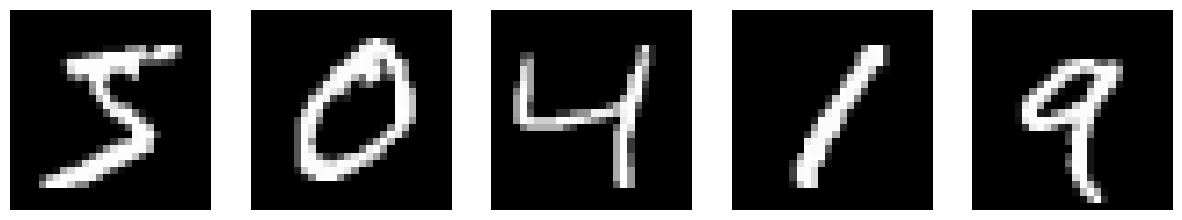

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 5, figsize=(15, 10))

for i in range(5):
    ax[i].imshow(X_train[i], cmap='gray')
    ax[i].axis('off')

In [4]:
y_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

## Работаем с данными

### Упрощаем задачу

Для простоты задачи возьмем для обучения только два класса, чтобы сделать задачу бинарной

In [9]:
idxs = np.where((y_train == 0) | (y_train == 1))
idxs

(array([    0,     1,     2, ..., 12662, 12663, 12664]),)

In [10]:
y_train = y_train[idxs]
X_train = X_train[idxs]

In [11]:
X_train.shape, y_train.shape

((12665, 28, 28), (12665,))

И все то же самое для теста:

In [12]:
idxs = np.where((y_test == 0) | (y_test == 1))
idxs

(array([   2,    3,    5, ..., 9984, 9993, 9994]),)

In [13]:
y_test = y_test[idxs]
X_test = X_test[idxs]

In [14]:
X_test.shape, y_test.shape

((2115, 28, 28), (2115,))

Визуализируем:

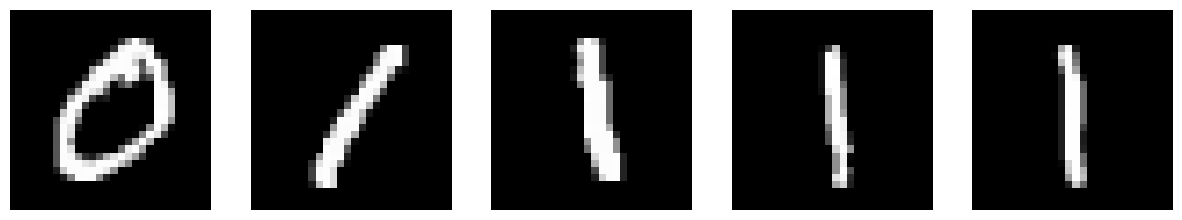

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(15, 10))

for i in range(5):
    ax[i].imshow(X_train[i], cmap='gray')
    ax[i].axis('off')

In [17]:
y_train[:5]

array([0, 1, 1, 1, 1], dtype=uint8)

### Норминуем данные

Размер пискеля в диапазоне от 0 до 255, а для нейросети комфортнее обучаться на диапазоне от 0 до 1. Поэтому надо сделать нормировку:

In [18]:
print(X_train.min(), X_train.max())

X_train = X_train / 255.0
X_test = X_test / 255.0

print(X_train.min(), X_train.max())

0 255
0.0 1.0


### Преобразуем метку класса

Нейросеть будет выдавать два значения: вероятнось принадлежности объекта к 0 и вероятность принадлежности объекта к 1. Следосательно, нам над изменить метку класса. Сейчас это лейбл 0 и 1, нужно преобразовать в бинарный вид. В результате получим два столбика:

In [24]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [25]:
y_train[:10]

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 0], dtype=uint8)

In [27]:
y_train_cat[:10]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

### Уменьшаем размер картинок

Для более быстрого обучения сети уменьшим размеры картинок:

In [33]:
X_train[..., np.newaxis].shape

(12665, 28, 28, 1)

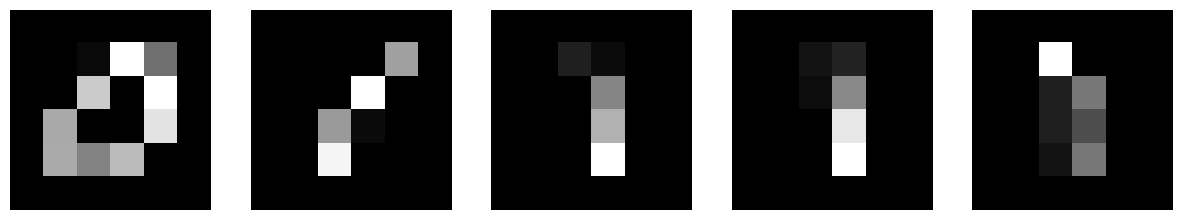

In [34]:
X_train_resized = tf.image.resize(X_train[..., np.newaxis], (6, 6))[..., 0]
X_test_resized = tf.image.resize(X_test[..., np.newaxis], (6, 6))[..., 0]

fig, ax = plt.subplots(1, 5, figsize=(15, 10))

for i in range(5):
    ax[i].imshow(X_train_resized[i], cmap='gray')
    ax[i].axis('off')

In [36]:
X_train_resized.shape

TensorShape([12665, 6, 6])

## Обучение нейронной сери

### Какая архитектура сети?

На вход поступает изображение 6 х 6, с ним нужно что-то делать, так как наша сеть не умеет работать с двумерным входом. Надо вытянуть изображение в один вектор размерностью 36:

Была матрица:

In [37]:
X_train_resized[0].numpy()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03594765, 0.9888889 , 0.42941174,
        0.        ],
       [0.        , 0.00228757, 0.7885626 , 0.        , 0.9901961 ,
        0.        ],
       [0.        , 0.65588236, 0.        , 0.        , 0.88235307,
        0.        ],
       [0.        , 0.66078436, 0.5088234 , 0.7235297 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]], dtype=float32)

In [38]:
X_train_resized[0].numpy().shape

(6, 6)

А теперь вектор:

In [39]:
X_train_resized[0].numpy().flatten()

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03594765, 0.9888889 ,
       0.42941174, 0.        , 0.        , 0.00228757, 0.7885626 ,
       0.        , 0.9901961 , 0.        , 0.        , 0.65588236,
       0.        , 0.        , 0.88235307, 0.        , 0.        ,
       0.66078436, 0.5088234 , 0.7235297 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)

In [40]:
X_train_resized[0].numpy().flatten().shape

(36,)

Наша сетка состоить из одного слоя:
- У нашей сети **36 входов** (это наши пиксели, вытянутые в один вектор)
- Они прогоняются через **два нейрона**. У каждого из которых есть 36 входов и bias
- Каждый нейрон выдает **веротность**: **первый** - быть нулевым классом, а **второй** - быть первый классом

In [45]:
tf.random.set_seed(9)

In [49]:
model = Sequential([
    Flatten(input_shape=(6, 6)),    # слой для вытягивания матрицы в вектор
    Dense(2, activation='sigmoid')  # полносвязный неронный слой
])

In [50]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            74 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74 (296.00 B)

 Trainable params: 74 (296.00 B)

 Non-trainable params: 0 (0.00 B)

### Что будем оптимизировать?

- Выбираем бинарную кросс-энтропию
- Еще будем считать метрику accuracy

### Как оптимизируем?

- Возьмем тот же градиетный спуск со стохастикой 

In [52]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

### Обучим модель

In [54]:
%%time
model.fit(X_train_resized, y_train_cat, epochs=5)

Epoch 1/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.9802 - loss: 0.2610
Epoch 2/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.9801 - loss: 0.2388
Epoch 3/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.9803 - loss: 0.2211
Epoch 4/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.9805 - loss: 0.2067
Epoch 5/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.9805 - loss: 0.1946
CPU times: user 2.17 s, sys: 141 ms, total: 2.31 s
Wall time: 1.77 s


## Сделаем предсказание

### На одной тестовой точке

In [55]:
print("Предсказание нейронной сети: ")
pred = model.predict(X_test_resized[:1])
pred

Предсказание нейронной сети: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


array([[0.12380333, 0.86137944]], dtype=float32)

В результате получили список из двух значений: вероятность быть нулевым классом и вероятность быть первым классом.

Чтобы выдать финальную метку класса можем взять класс, где максимальная предсказанная вероятность:

In [57]:
pred_cls = pred.argmax()
pred_cls

1

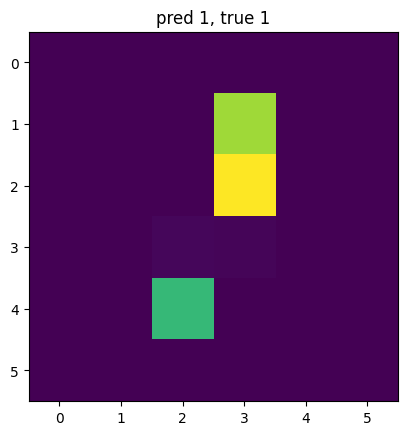

In [58]:
idx = 0
plt.imshow(X_test_resized[idx])
plt.title(f'pred {pred_cls}, true {y_test[idx]}');

Посмотрим на исходное изборажение до уменьшения размера

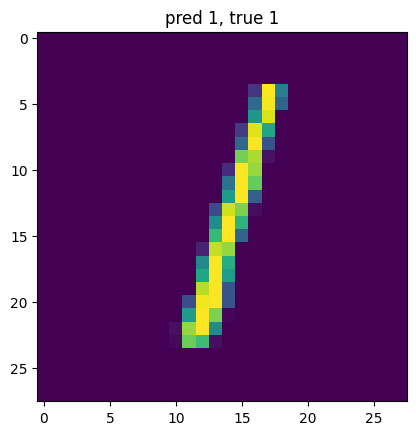

In [59]:
plt.imshow(X_test[idx])
plt.title(f"pred {pred_cls}, true {y_test[idx]}");

### На всех тестовых объектах

In [60]:
preds = model.predict(X_test_resized)
preds

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


array([[0.12380333, 0.86137944],
       [0.9480692 , 0.05773922],
       [0.09125636, 0.90169764],
       ...,
       [0.07483093, 0.9216793 ],
       [0.94150066, 0.09788344],
       [0.09944493, 0.9048685 ]], dtype=float32)

In [61]:
preds_cls = preds.argmax(axis=1)
preds_cls

array([1, 0, 1, ..., 1, 0, 1])

### Считаем метрики качества

In [62]:
from sklearn.metrics import accuracy_score

In [64]:
print(f"test acc: {accuracy_score(y_test, preds_cls)*100: 2f}% ({(y_test == preds_cls).sum()} out of {y_test.shape[0]})")

test acc:  98.723404% (2088 out of 2115)


Очень хороший результат: угадали 2088 объектов из 2115